In [1]:
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
# Read the files in the Data Folder
files = os.listdir("Data/")
print(files)

# Generate the labels for each video class
labels = [i for i in range(len(files))]
print(labels)

['Bend', 'Jack', 'Jump', 'Pjump', 'Run', 'Side', 'Skip', 'Walk', 'Wave1', 'Wave2']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [3]:
# This function computes the optical flow for all the consequitive frames of the video
def optical_flow(cap):
    Flow = []
    ret, old_frame = cap.read()
    while True:
        ret, new_frame = cap.read()
        if ret:
            prvs = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
            new = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prvs, new, None,0.5, 3, 15, 3, 5, 1.2, 0)
            Flow.append(flow)
            old_frame = new_frame
        else:
            break
    return np.array(Flow)

In [4]:
def optical_flow_amp(Flow):
    AMP = []
    for flow in Flow:
        u = flow[...,0] 
        v = flow[...,1]

        amp = np.sqrt(u**2 + v**2) 
        AMP.append(amp)
    return np.array(AMP)

In [5]:
def amp_threshold(AMP):
    alpha = 0.15
    threshold = alpha * np.max(AMP)
    for i in range(len(AMP)):

        AMP[i][AMP[i]<threshold] = 0
        AMP[i][AMP[i]>=threshold] = 1
    return AMP

In [6]:
def MHI(cap):
    
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    Flow = optical_flow(cap)
    Flow_AMP = optical_flow_amp(Flow)
    AMP_Threshold = amp_threshold(Flow_AMP)
    
    
    MHI_old = np.zeros((frameHight,frameWidth))
    MHI_new = np.zeros((frameHight,frameWidth))
    
    tau = frameCount - 1
    for i in range(tau):
        if i == 0:
            MHI_old[AMP_Threshold[i] == 1] = tau
        else:
            MHI_new[AMP_Threshold[i] == 1] = tau
            MHI_new[AMP_Threshold[i] == 0] = np.maximum(MHI_old[AMP_Threshold[i] == 0]-1,0)

            MHI_old = MHI_new
            
    return MHI_new

In [7]:
Data_path = "Data/"
video_path = Data_path + files[5]

Bend_videos = os.listdir(video_path)
print(Bend_videos[0])
Example_video = video_path+ "/" + Bend_videos[0]

clip1 = VideoFileClip(Example_video)
cap = cv2.VideoCapture(Example_video)

daria_side.avi


In [8]:
clip1.ipython_display(width = 250)

 98%|███████████████████████████████████████████████████████████████████████████████▌ | 53/54 [00:00<00:00, 467.75it/s]


(144, 180)
<class 'numpy.ndarray'>


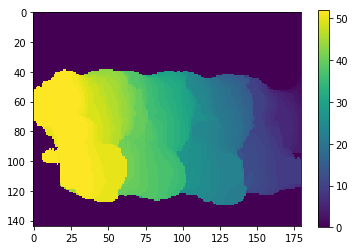

In [9]:
MHI_image = MHI(cap)
print(MHI_image.shape)
print(type(MHI_image))
plt.figure()
plt.imshow(MHI_image)
plt.colorbar()
plt.show()

In [10]:
label_list = []
label_number = 0

for file in files:
    label_number+=1
    class_path = Data_path + file
    videos_list = os.listdir(class_path)
    
    for video_name in videos_list:
        label_list.append(label_number)
label_list = np.array(label_list)
print(label_list.shape)

(93,)


In [11]:
MHI_list = []

for file in files:
    label_number+=1
    class_path = Data_path + file
    
    videos_list = os.listdir(class_path)
    
    for video_name in videos_list:
        
        video_path = class_path + "/" + video_name
        
        cap = cv2.VideoCapture(video_path)
        MHI_image = MHI(cap)
        
        MHI_list.append(MHI_image)

MHI_data = np.array(MHI_list)

In [12]:
print(MHI_data.shape)

(93, 144, 180)


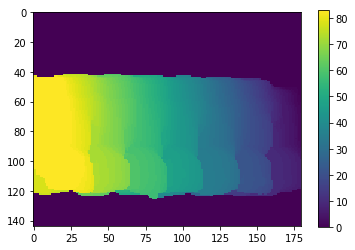

In [13]:
plt.figure()
plt.imshow(MHI_data[65])
plt.colorbar()
plt.show()

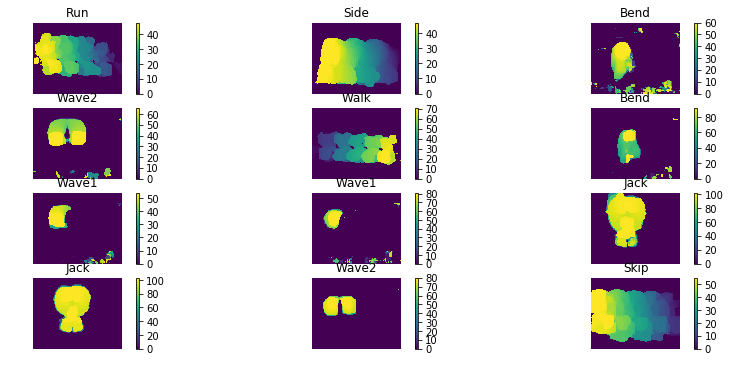

In [15]:
fig, axs = plt.subplots(4, 3, figsize = (15,6))
fig.subplots_adjust (hspace = 0.2, wspace = 0.001)
axs = axs.ravel()

for i in range(12):
    index = random.randint(0, len(MHI_data)-1)
    label_index = label_list[index]
    axs[i].axis('off')
    im = axs[i].imshow(MHI_data[index])
    fig.colorbar(im,ax = axs[i])
    axs[i].set_title(files[label_index-1])

In [16]:
# Normalization Function
def Normalize(X):
    
    for i in range(len(X)):

        mean = np.mean(X[i])
        std = np.sqrt(np.var(X[i]))

        X[i] = (X[i]-mean)/std
    
    return X

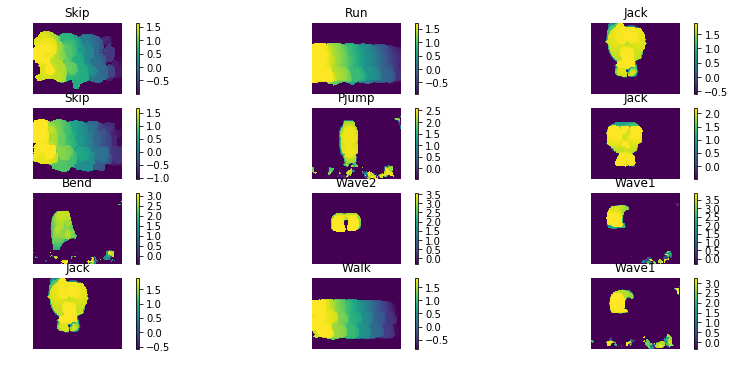

In [17]:
X_normalized = Normalize(MHI_data)
fig, axs = plt.subplots(4, 3, figsize = (15,6))
fig.subplots_adjust (hspace = 0.2, wspace = 0.001)
axs = axs.ravel()

for i in range(12):
    index = random.randint(0, len(MHI_data)-1)
    label_index = label_list[index]
    axs[i].axis('off')
    im = axs[i].imshow(X_normalized[index])
    fig.colorbar(im,ax = axs[i])
    axs[i].set_title(files[label_index-1])



In [18]:
X_normalized = np.expand_dims(X_normalized, axis = 3)
print(X_normalized.shape)

(93, 144, 180, 1)


In [19]:
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, MaxPooling2D, Activation, Dropout

In [20]:
model = Sequential()

model.add(Convolution2D(6, 5, 5, input_shape = (144, 180, 1)))
model.add(Activation("relu"))

model.add(MaxPooling2D((2,2), strides= (2,2), border_mode= 'valid'))

model.add(Convolution2D(16,5,5))
model.add(Activation('relu'))

model.add(MaxPooling2D((2,2), strides= (2,2), border_mode= 'valid'))

model.add(Flatten())

model.add(Dense(120))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(84))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

In [21]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(label_list)

In [28]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, nb_epoch =100, validation_split = 0.0, shuffle = True)

Epoch 1/100
93/93 [==============================] - ETA: 1s - loss: 0.2207 - acc: 0.906 - ETA: 0s - loss: 0.1251 - acc: 0.953 - 1s - loss: 0.1003 - acc: 0.9677     
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 0.3797 - acc: 0.937 - ETA: 0s - loss: 0.1978 - acc: 0.968 - 1s - loss: 0.1823 - acc: 0.9570     
Epoch 3/100
93/93 [==============================] - ETA: 0s - loss: 0.1619 - acc: 0.937 - ETA: 0s - loss: 0.0905 - acc: 0.968 - 1s - loss: 0.0813 - acc: 0.9677     
Epoch 4/100
93/93 [==============================] - ETA: 0s - loss: 0.0154 - acc: 1.000 - ETA: 0s - loss: 0.1052 - acc: 0.968 - 1s - loss: 0.0941 - acc: 0.9677     
Epoch 5/100
93/93 [==============================] - ETA: 1s - loss: 0.0654 - acc: 0.968 - ETA: 0s - loss: 0.0351 - acc: 0.984 - 1s - loss: 0.0301 - acc: 0.9892     
Epoch 6/100
93/93 [==============================] - ETA: 1s - loss: 0.1089 - acc: 0.937 - ETA: 0s - loss: 0.0736 - acc: 0.953 - 1s - loss: 0.0946 - acc: 0.9570     
Epoc

93/93 [==============================] - ETA: 0s - loss: 0.0392 - acc: 0.968 - ETA: 0s - loss: 0.0605 - acc: 0.968 - 1s - loss: 0.0510 - acc: 0.9785     
Epoch 51/100
93/93 [==============================] - ETA: 0s - loss: 0.1889 - acc: 0.937 - ETA: 0s - loss: 0.0959 - acc: 0.968 - 1s - loss: 0.0975 - acc: 0.9677     
Epoch 52/100
93/93 [==============================] - ETA: 1s - loss: 0.0135 - acc: 1.000 - ETA: 0s - loss: 0.0161 - acc: 1.000 - 1s - loss: 0.0111 - acc: 1.0000     
Epoch 53/100
93/93 [==============================] - ETA: 0s - loss: 0.1341 - acc: 0.937 - ETA: 0s - loss: 0.1259 - acc: 0.953 - 1s - loss: 0.0910 - acc: 0.9677     
Epoch 54/100
93/93 [==============================] - ETA: 1s - loss: 0.0144 - acc: 1.000 - ETA: 0s - loss: 0.0097 - acc: 1.000 - 1s - loss: 0.0075 - acc: 1.0000     
Epoch 55/100
93/93 [==============================] - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0042 - acc: 1.000 - 1s - loss: 0.0040 - acc: 1.0000     
Epoch 56/10

Epoch 99/100
93/93 [==============================] - ETA: 0s - loss: 0.0311 - acc: 0.968 - ETA: 0s - loss: 0.0169 - acc: 0.984 - 1s - loss: 0.0194 - acc: 0.9785     
Epoch 100/100
93/93 [==============================] - ETA: 0s - loss: 2.5518e-04 - acc: 1.000 - ETA: 0s - loss: 0.0025 - acc: 1.0000    - 1s - loss: 0.0135 - acc: 1.0000     
